<a href="https://colab.research.google.com/github/JR-1991/Catalax/blob/master/examples/Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import catalax
except ImportError:
    !pip install git+https://github.com/JR-1991/Catalax.git

/Users/jara1991/anaconda3/envs/catalax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import jax
import jax.numpy as jnp
import numpy as np

from catalax import Model, visualize, optimize

jax.config.update("jax_enable_x64", True)

In [3]:
# Initialize the model
model = Model(name="Simple menten model")

# Add species
model.add_species("s1")

# Add ODEs
model.add_ode("s1", "- (v_max * s1) / ( K_m + s1)")

# Prepare the model for bayes and define priors 
model.parameters.v_max.value = 7.0
model.parameters.K_m.value = 100.0

model

Model summary


Eq(x, Matrix([[s1]]))

Eq(theta, Matrix([[v_max, K_m]]))

Eq(Derivative(s1, t), -s1*v_max/(K_m + s1))

,name,symbol,value,constant,initial_value,equation,lower_bound,upper_bound
0,K_m,K_m,100.0,False,None,None,None,None
1,v_max,v_max,7.0,False,None,None,None,None


In [4]:
# Generate irregular time series data
# from a simple menten model

# Data is sampled at different time points
# and also not at zero to reflect realistic
# scenarios
time = jnp.array([
    [10, 30 ,50 ,70 ,90, 100],
    [15, 35, 55, 78, 98, 108],
    [11, 23, 41 , 68, 86, 110],
    [23, 41, 68, 86, 110, 130],
])

# Set initial conditions above and below the 
# true Km value for the sake of the example
initial_conditions = [
    {"s1": 300.0},
    {"s1": 200.0},
    {"s1": 80.0},
    {"s1": 50.0},
]

time, data = model.simulate(
    initial_conditions=initial_conditions,
    dt0=0.1, saveat=time, in_axes=(0, None, 0)
)

# Add some noise for realism
data = np.random.normal(data, 3.0).clip(min=0)

print(f"Time: {time.shape} | Data: {data.shape}")

Time: (4, 6) | Data: (4, 6, 1)


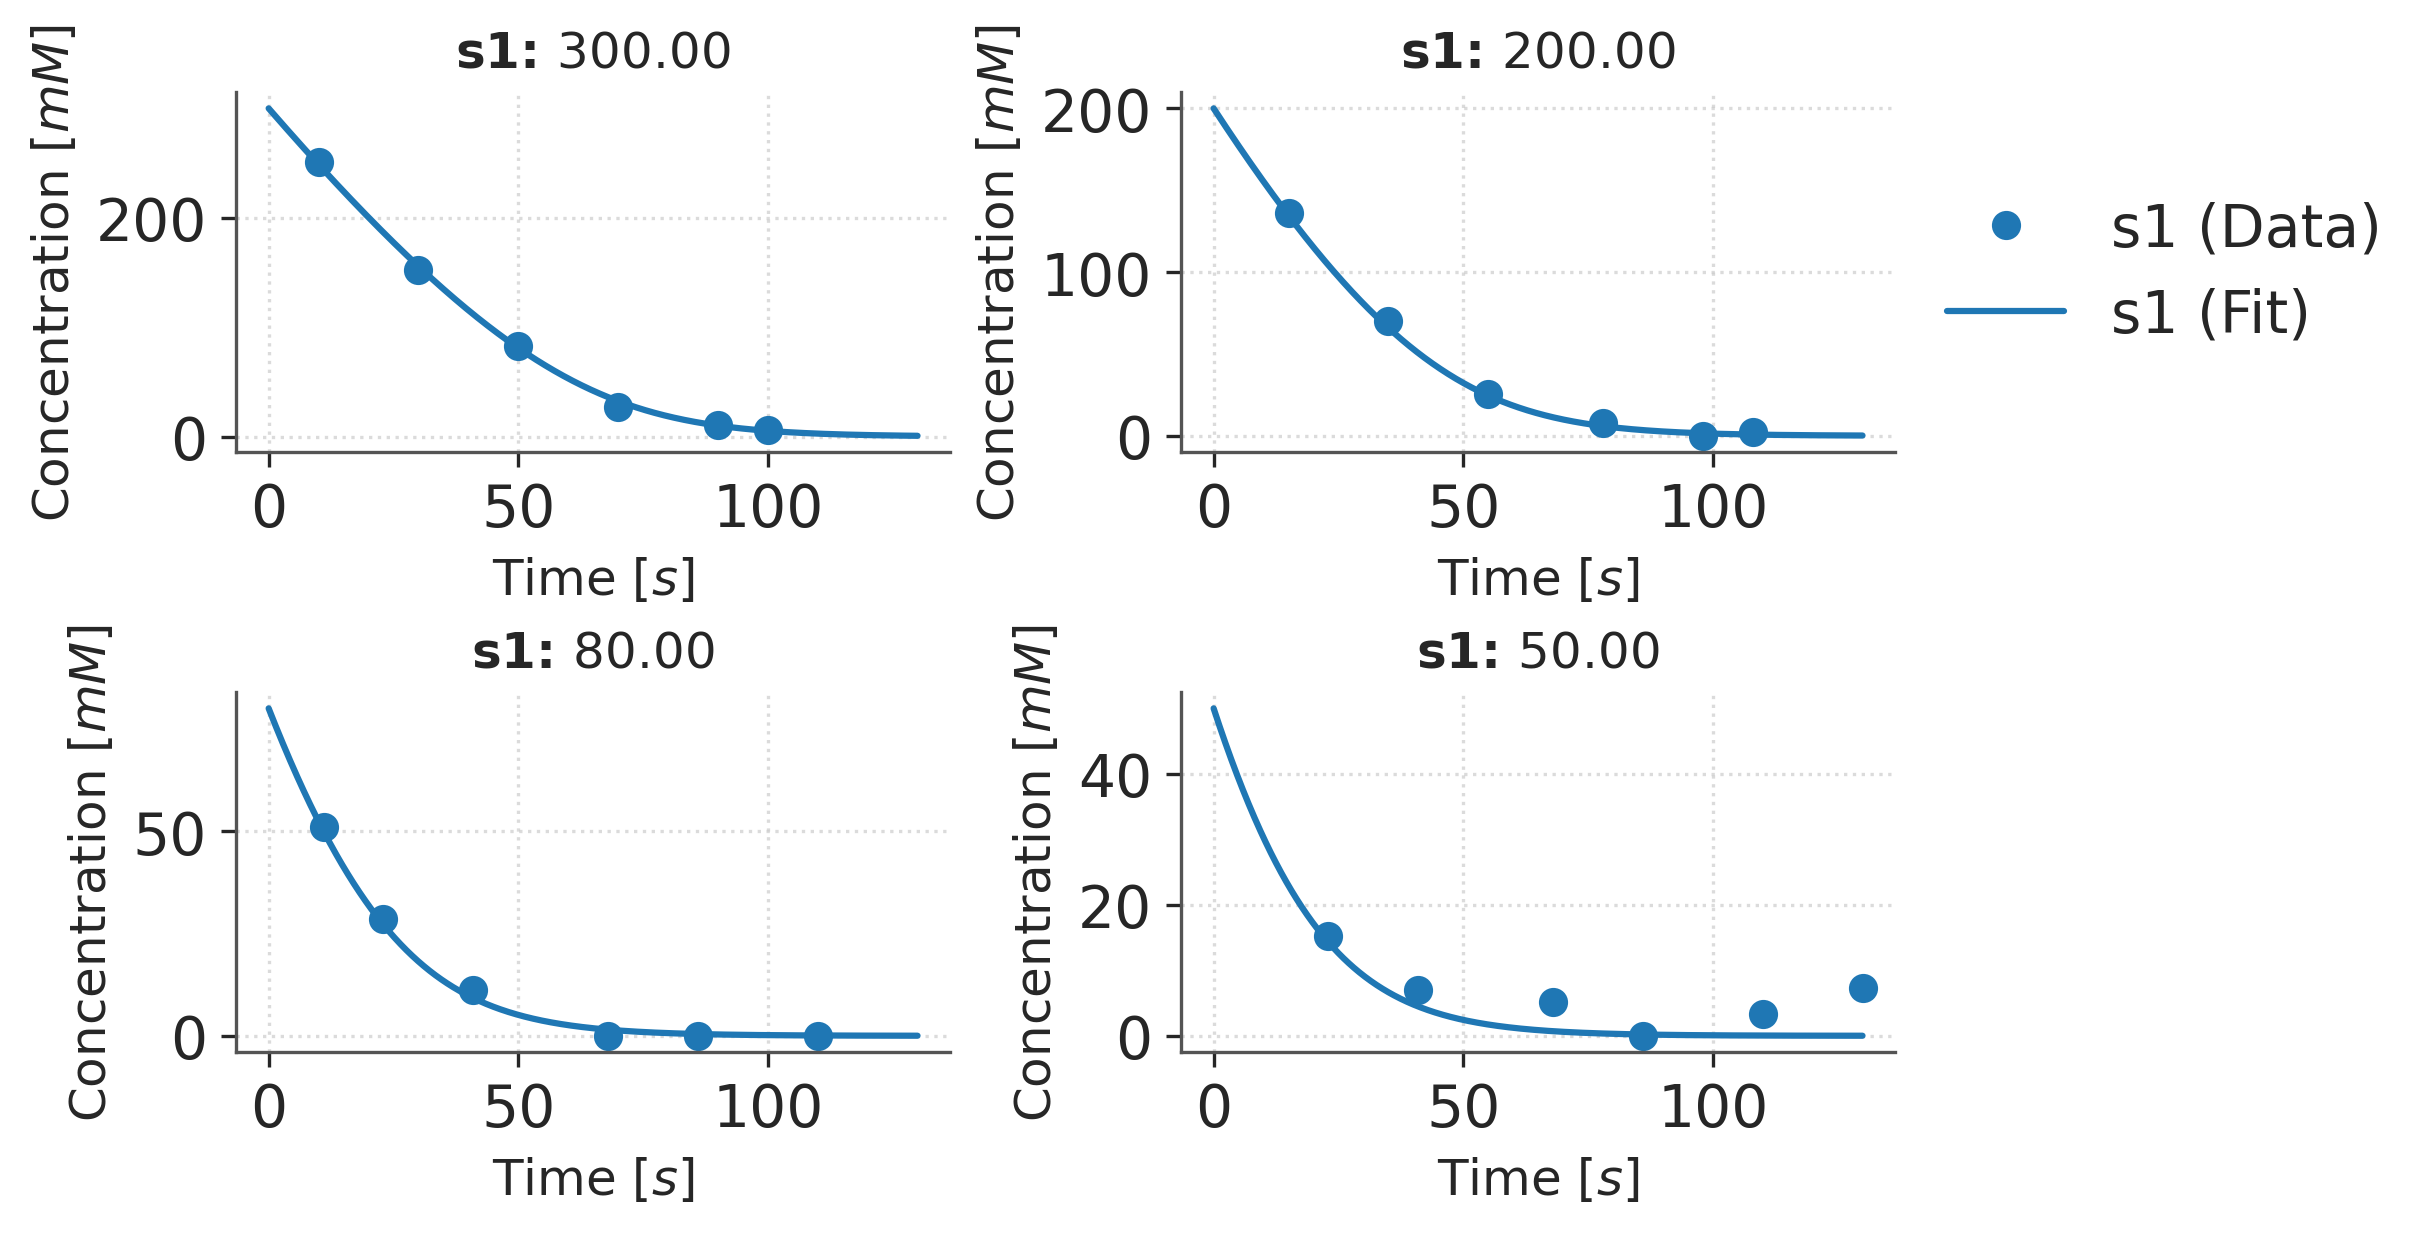

In [5]:
f = visualize(
    model=model,
    data=data,
    times=time,
    initial_conditions=initial_conditions,
    figsize=(4,2),
)

In [6]:
# In order to perform optimization, we need to add initial values.
model.parameters.v_max.initial_value = 10.0
model.parameters.K_m.initial_value = 120.0

# ... and to make sure to be as realistic as possible.
model.parameters.v_max.value = None
model.parameters.K_m.value = None

In [7]:
# Perform the optimization
result, new_model = optimize(
    model=model,
    initial_conditions=initial_conditions,
    data=data,
    times=time,
    global_upper_bound=1e5,
    global_lower_bound=1e-6,
    method="bfgs"
)

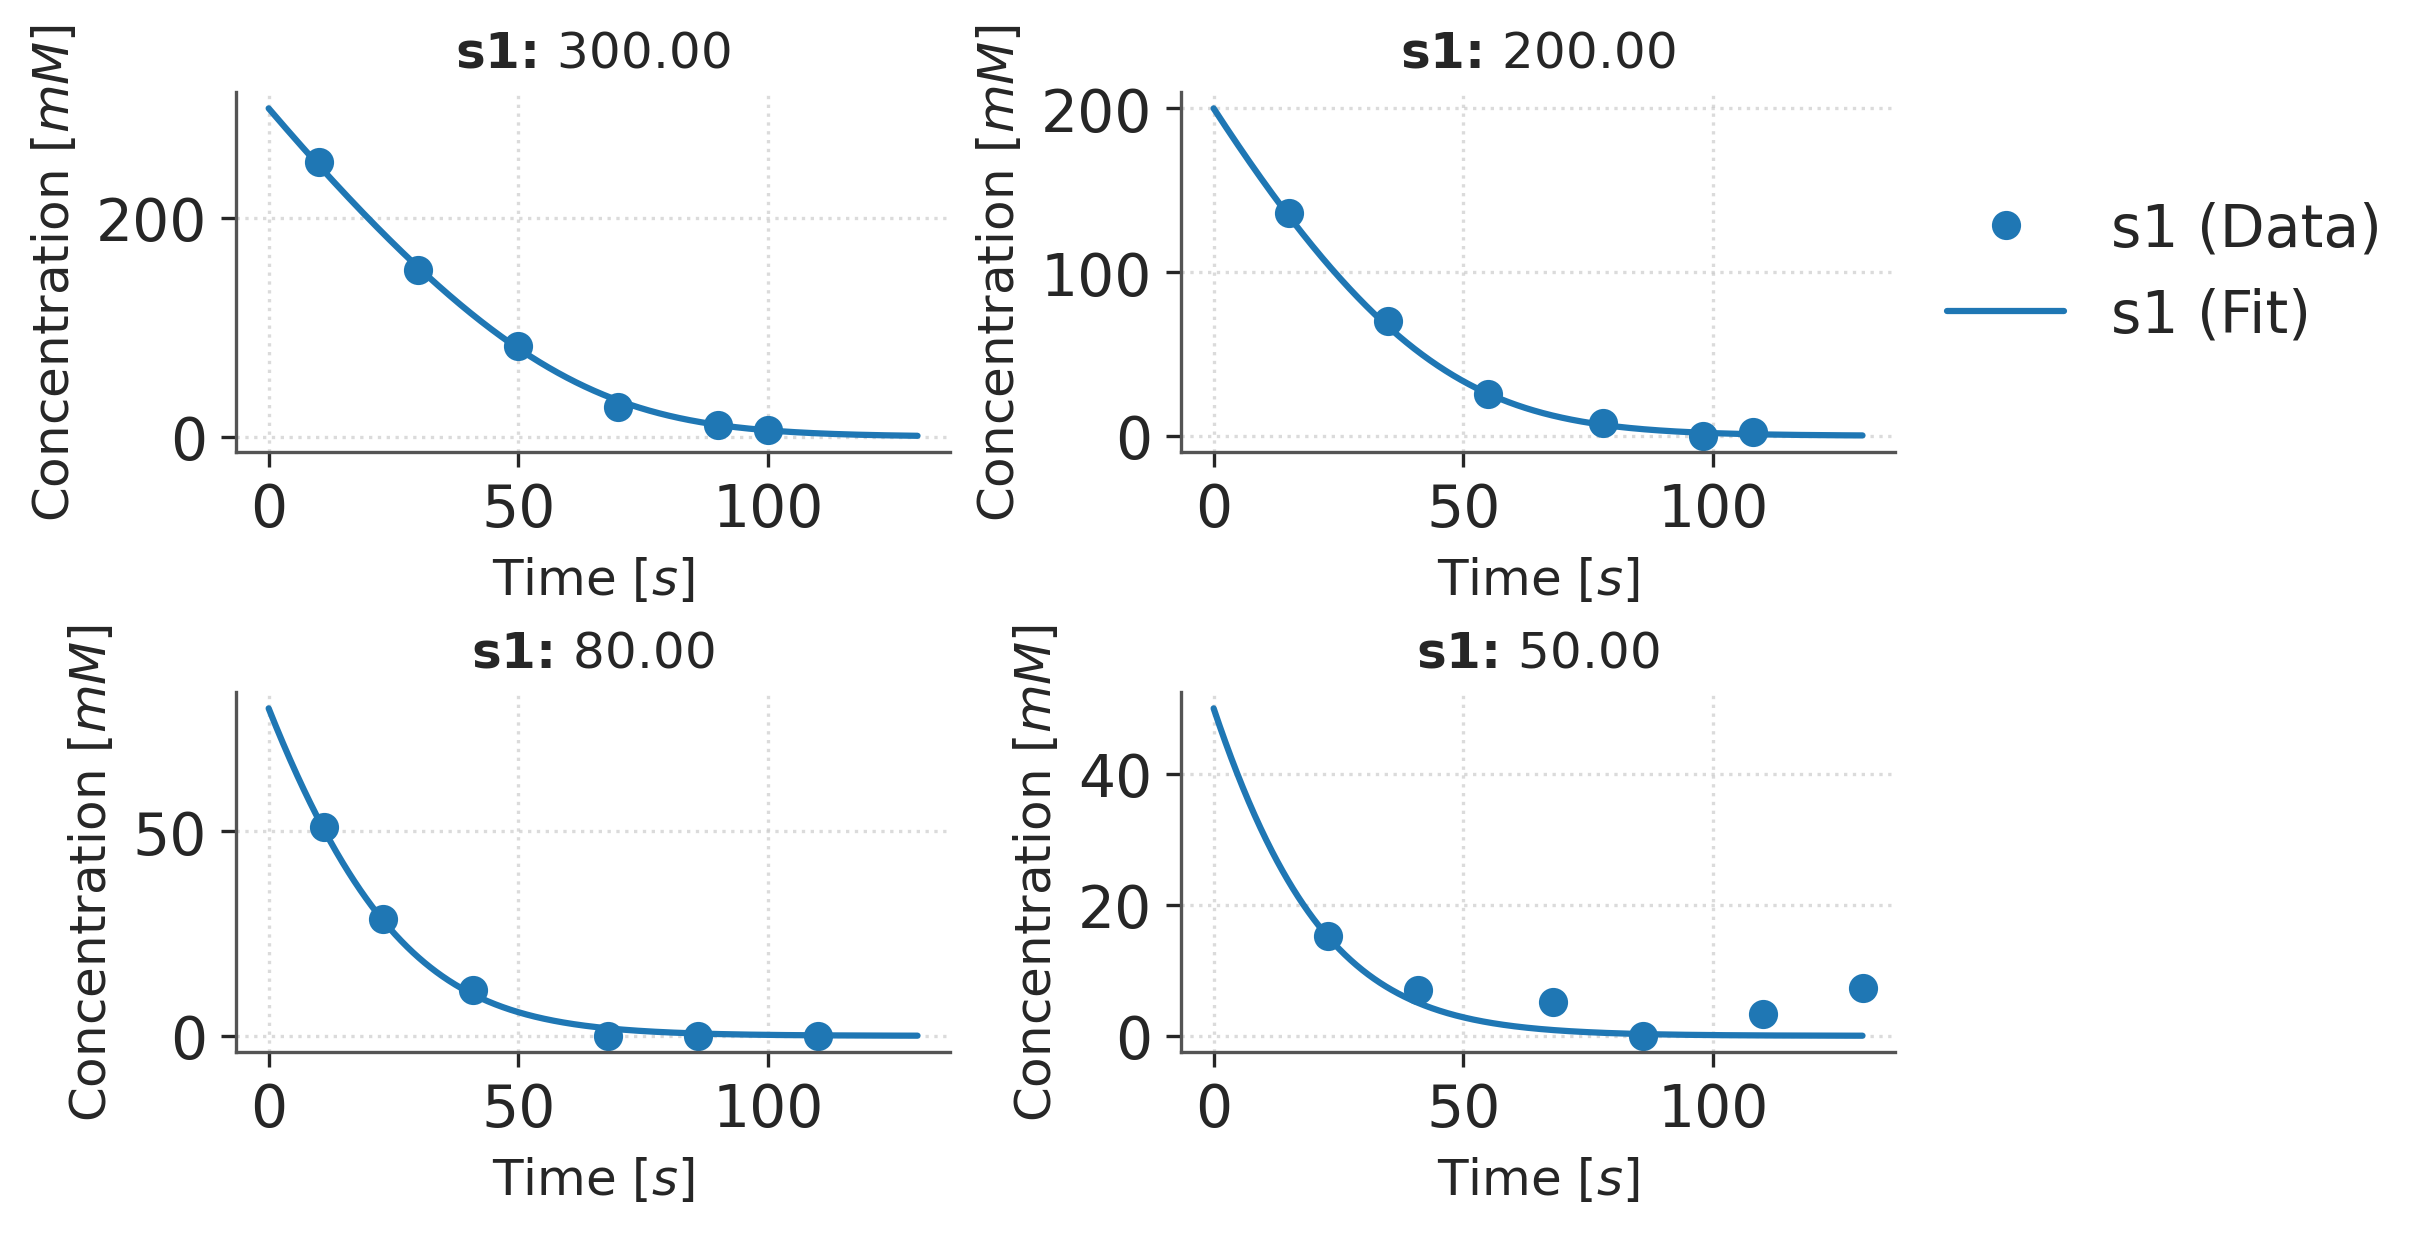

In [8]:
f = visualize(
    model=new_model,
    data=data,
    times=time,
    initial_conditions=initial_conditions,
    figsize=(4,2),
)